# US wildfires
### Import Data and Libraries

In [1]:
import datetime
from jdcal import jd2gcal
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt

import cdsapi
import sklearn_pandas as skp
from shapely.geometry import Point
import altair as alt
from vega_datasets import data
import plotly.express as px
import panel as pn
pn.extension('plotly')

custom_colors = ['#68A33E', '#A10702', '#FB9E60', '#FFFF82', '#0F0326']

### Load in Raw Data

In [2]:
input_filename = 'FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
       *
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)

## Clean Data

In [3]:
drop_columns = ['NWCG_REPORTING_AGENCY',
                'NWCG_REPORTING_UNIT_ID',
                'NWCG_REPORTING_UNIT_NAME',
                'FIRE_NAME',
                'COMPLEX_NAME', 
                'OWNER_DESCR',
                'OWNER_CODE']
df_US = df_raw.drop(columns= drop_columns)
df_US['MONTH'] = df_US['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[1])
df_US['DAY'] = df_US['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[2])

In [4]:
geometry = [Point(xy) for xy in zip(df_US['LONGITUDE'], df_US['LATITUDE'])]
df_geo = gpd.GeoDataFrame(df_US, geometry=geometry)
df_geo.crs = "EPSG:4326"

In [5]:
states = alt.topo_feature(data.us_10m.url, feature='states')
us_states = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
us_states_geojson = 'states.json' 


In [6]:
import plotly.express as px
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

In [7]:
df_grouped = df_geo.groupby(['STATE'], as_index=False).agg({'LATITUDE': 'mean', 'LONGITUDE': 'mean', 'FIRE_SIZE': 'sum' })

In [8]:
scaler = MinMaxScaler(feature_range=(1, 10))
df_grouped['markersize'] = scaler.fit_transform(df_grouped[['FIRE_SIZE']])

In [9]:
import panel as pn
pn.extension('plotly')
def create_dashboard():
    # Create a scatter_geo figure
    fig = px.scatter_geo(
        df_grouped,
        locations='STATE',
        locationmode='USA-states',
        color='FIRE_SIZE',
        size='markersize',
        hover_name='STATE',
        projection='natural earth',
        title='Wildfires in US States',
        template='plotly',
    )

    # Update geos settings
    fig.update_geos(
        center=dict(lon=-100, lat=40),
        projection_scale=2,
        showcoastlines=True,
        coastlinecolor='black',
        showsubunits=True,
        subunitcolor='black',
        subunitwidth=2,
        landcolor='darkgrey',
        showocean=True,
        oceancolor='azure',
    )

    return pn.pane.Plotly(fig)

# Create the Panel app
app = pn.Column("## Wildfires Dashboard", create_dashboard)

# Display the app
app.servable()

Column
    [0] Markdown(str)
    [1] Column
        [0] Column()
        [1] Row
            [0] Plotly(Figure)

To begin investigating trends in wildfires across Oregon, it is important to first consider the larger national perspective. The map above details the total acreage burned in each state. Overall, Alaska far surpasses any other state, while California and Idaho show the highest amount burned in the continental US. These trends are expected, however, as these states are larger than others seen throughout the country, particularly along the midwest and eastern coast.
To learn more, hover over each state to explore details including the amount of area burned. Please look at the hyperlinked figure; sometimes the panel and html don't render correctly at [figure](scatter_geo_chart.html)

## Fire cause by state

In [10]:
df_viz = df_geo.groupby(['STATE', 'STAT_CAUSE_DESCR']).size().reset_index(name='Number_of_Fires')

chart = alt.Chart(df_viz).mark_bar().encode(
    x='sum(Number_of_Fires):Q',
    y=alt.Y('STATE:N', sort='-x'),
    color='STAT_CAUSE_DESCR:N',
    tooltip=['STATE:N', 'STAT_CAUSE_DESCR:N', 'sum(Number_of_Fires):Q']
).interactive()

chart

alt.Chart(...)

## Monthly/Seasonaly fire frequency

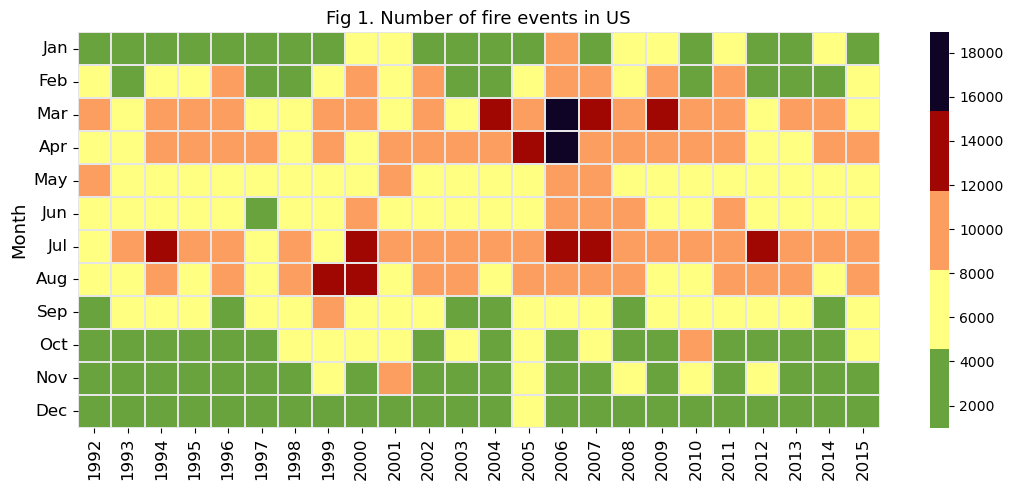

In [11]:
custom_colors = ['#68A33E','#FFFF82','#FB9E60','#A10702', '#0F0326']  # Add your desired hex colors
df_freq_mon = df_geo.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
df_freq_mon.to_csv("wildfireDataUS.csv")
# plot monthly frequency of fire events
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title(f'Fig {counter_fig}. Number of fire events in US', fontsize=13)
plt.tight_layout()


The visualization above shows spread of recorded wildfires across the year, with the darker colors indicating more instances of wildfire.  Across the last 24 years, late spring and late summer saw the most burning, with a period of increased fires during the spring of 2006. On average, less than 8,000 fires burn per month across the US - however, certain months tend to tell another story, where more than 16,000 burned in the same time period. There appears to be a slight dip in fires during the early summer months of May and June.

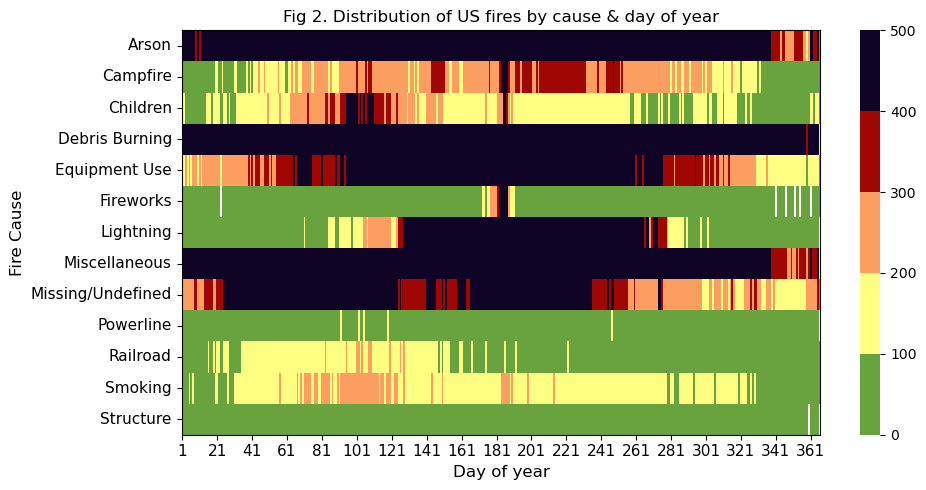

In [12]:
# plot fire frequency by cause and day of year
cause_by_doy = df_geo.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap=custom_colors,vmin=0,vmax=500) #'CMRmap_r' <- old color scheme
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title(f'Fig {counter_fig}. Distribution of US fires by cause & day of year')
plt.tight_layout()


Next, we observe which activities are the most likely causes of wildfires across the country depending on the time of year. According to the visualization above, arson, debris burning, and other mixed causes are commonplace throughout the year, while other common reasons tend to spike in specific seasons. For example, lightning strikes and equipment use are common causes during the summertime, when summer storms bring seasonal spikes in thundering clouds, and when people are more likely to get outside and run types of equipment that have the ability to catch ablaze.
An interesting observation lies in the missing and undefined category, which is most likely to be recorded in the first half of the year.


## Causes by year

In [13]:
fig_q = px.sunburst(df_geo, path=['FIRE_YEAR', 'MONTH', 'STAT_CAUSE_DESCR'], title='Main Causes of Fire by Month and Year')
fig_q.update_layout(margin=dict(l=0, r=0, b=0, t=40))  # Adjust layout if needed

# Save the figure as an HTML file
fig_q.write_html("sunburst_chart.html")


```{html}
<iframe src="sunburst_chart.html" width="100%" height="600"></iframe>


Finally, we observe trends in common causes of wildfires by year. To interact with the visualization, select a year from the center of the wheel. The information becomes increasingly detailed as the wheel is explored outwards.